# Code for Setence Classification using Graph Neural Networks

## Summary

### Task

The task to construct language models to classify IMDB reviews based on their sentiment (positive or negative).

### Model

The model is a bilstm with graph regularization. The graph in constructed from pretrained embeddings from transformer networks.

### Experiments

The experiments we run will help determine the accuracy and interpretability of our model.

The stats to look for are: accuracy, precision, recall, and AUPRC

Another potential question is robustness, is our model better at telling apart sentences with negative statements. What about adversarially generated sentences?

### Results

TBD

### Analysis

What was important and what did we learn?

### Conclusion

How do we feel about the performance and utility of graphs for sentiment analysis on sentence level tasks?

What can we do to identify and fix problems in our approach?

## Importing Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import neural_structured_learning as nsl
import tensorflow_text as text  
import tensorflow as tf
import tensorflow_hub as hub

# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


### Some custom Imports

In [3]:
from tfRecordTools import *

## Load Data

The first step is to load our data from the imdb database

In [4]:
imdb = tf.keras.datasets.imdb
(pp_train_data, pp_train_labels), (pp_test_data, pp_test_labels) = (
    imdb.load_data(num_words=10000))

In [5]:
# This block limits how much is loaded to keep debugging short
# don't run on the final experiments

limit = 1000

pp_train_data = pp_train_data[0:limit]
pp_train_labels = pp_train_labels[0:limit]
pp_test_data = pp_test_data[0:limit]
pp_test_labels = pp_test_labels[0:limit]

In [93]:
print('Training entries: {}, labels: {}'.format(
    len(pp_train_data),
    len(pp_train_labels)
))
training_samples_count = len(pp_train_data)

Training entries: 1000, labels: 1000


In [137]:
print(pp_train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [95]:
len(pp_train_data[0]), len(pp_train_data[1])

(218, 189)

Let's define some helper functions to convert the index back to words with proper accounting for the special characters reserved at the beginning of the dictionary.

In [96]:
def build_reverse_word_index():
    """
    A dictionary mapping words to an integer index
    """
    word_index = imdb.get_word_index()

    # The first indices are reserved
    word_index = {k: (v + 3) for k, v in word_index.items()}
    word_index['<PAD>'] = 0
    word_index['<START>'] = 1
    word_index['<UNK>'] = 2  # unknown
    word_index['<UNUSED>'] = 3
    return dict((value, key) for (key, value) in word_index.items())


reverse_word_index = build_reverse_word_index()


def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [97]:
decode_review(pp_train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Testing out tensorflow text
(if you run this code block and chidlren do not run the sibling blocks)

In [84]:
pretrained_embedding = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2'

In [85]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',
    trainable=True)

outputs = encoder(encoder_inputs)

pooled_output = outputs['pooled_output'] # [batch_size, 128].
# [batch_size, seq_length, 128].

sequence_output = outputs['sequence_output']

2022-05-18 23:30:58.443603: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-18 23:30:58.458621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [129]:
def createBertEmbeddingExample(word_vector, record_id):
    """
    Create tf.Example containing the sample's embedding and its ID.
    
    
    """

    text = decode_review(word_vector)

    # Shape = [batch_size,].
    sentence_embedding = encoder(preprocessor(tf.reshape(text, shape=[-1, ])))['pooled_output']
    
    # Flatten the sentence embedding back to 1-D.
    sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])
    
    features = {
        'id': _bytes_feature(str(record_id)),
        'embedding': _float_feature(sentence_embedding.numpy())
    }
    return tf.train.Example(features=tf.train.Features(feature=features))


def createBertEmbedding(word_vectors, output_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(output_path) as writer:
        for word_vector in word_vectors:
            example = createBertEmbeddingExample(word_vector, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id

In [131]:
createBertEmbeddingExample(pp_train_data[0], 0)

features {
  feature {
    key: "embedding"
    value {
      float_list {
        value: -0.9970534443855286
        value: 0.131486177444458
        value: -0.9839852452278137
        value: 0.9861465096473694
        value: -0.9971204400062561
        value: 0.856085479259491
        value: -0.9944372773170471
        value: -0.13611185550689697
        value: -0.033533722162246704
        value: 0.1380845159292221
        value: -0.8371204733848572
        value: 0.012691838666796684
        value: -0.05454445630311966
        value: 0.9937337040901184
        value: -0.622428297996521
        value: -0.9658992886543274
        value: 0.9696784615516663
        value: 0.005809218622744083
        value: -0.8203678131103516
        value: 0.979274570941925
        value: 0.7504119277000427
        value: 0.05522230267524719
        value: 0.9424341320991516
        value: 0.07357314974069595
        value: -0.999937117099762
        value: -0.03137080371379852
        value: -0.9918

In [100]:
bertEmbeddingsPath = '/tmp/imdb/bertEmeddings.tfr'
# don't the run line below unless if you want to generate a new bert embeddings
createBertEmbedding(pp_train_data, bertEmbeddingsPath, 0)

1000

In [132]:
!wc -l /tmp/imdb/bertEmeddings.tfr

    9303 /tmp/imdb/bertEmeddings.tfr


### Constructing the BERT Graph

In [133]:
pp_train_data.shape

(1000,)

In [134]:
bertGraphPath = '/tmp/imdb/bert_graph_99.tsv'

In [135]:
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=0.99,
    lsh_splits=32,
    lsh_rounds=15,
    random_seed=12345)

nsl.tools.build_graph_from_config([bertEmbeddingsPath],
                                  bertGraphPath,
                                  graph_builder_config)

In [136]:
!wc -l /tmp/imdb/bert_graph_99.tsv

      58 /tmp/imdb/bert_graph_99.tsv


### Get the Training and Testing Samples

In [ ]:
def create_example(word_vector, label, record_id):
    """
    Create tf.Example containing the sample's word vector, label, and ID.
    """
    features = {
        'id': _bytes_feature(str(record_id)),
        'words': _int64_feature(np.asarray(word _vector)),
        'label': _int64_feature(np.asarray([label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=features))


def create_records(word_vectors, labels, record_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(record_path) as writer:
        for word_vector, label in zip(word_vectors, labels):
            example = create_example(word_vector, label, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id

In [ ]:
# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data,
                                pp_train_labels,
                                '/tmp/imdb/train_data.tfr',
                                0)
create_records(pp_test_data,
               pp_test_labels,
               '/tmp/imdb/test_data.tfr',
               next_record_id)

### Augment the Data using graph

In [ ]:
bertNSLPath = '/tmp/imdb/nslBert_train_data.tfr'

In [ ]:

nsl.tools.pack_nbrs(
    '/tmp/imdb/train_data.tfr',
    '',
    bertGraphPath,
    '/tmp/imdb/nsl_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3)

## Constructing the Graph

### Sample Embeddings

There are swivel embeddings but can also use other embeddings like BERT

Make a directory to store the data here `mkdir -p /tmp/imdb`

In [ ]:
!mkdir -p /tmp/imdb

In [8]:
pretrained_embedding = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'

In [9]:
hub_layer = hub.KerasLayer(
    pretrained_embedding,
    input_shape=[],
    dtype=tf.string,
    trainable=True)

Metal device set to: Apple M1 Max


2022-05-13 13:54:35.896819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 13:54:35.896940: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-13 13:54:35.919345: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 13:54:35.932307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Now construct the embeddings for the sentences using the loadded pretrained swivel embeddings

In [79]:
def create_embedding_example(word_vector, record_id):
    """
    Create tf.Example containing the sample's embedding and its ID.
    """

    text = decode_review(word_vector)
    # hub_layer(text)
    # Shape = [batch_size,].
    sentence_embedding = hub_layer(tf.reshape(text, shape=[-1, ]))    
    # Flatten the sentence embedding back to 1-D.
    sentence_embedding = tf.reshape(sentence_embedding, shape=[-1])

    features = {
        'id': _bytes_feature(str(record_id)),
        'embedding': _float_feature(sentence_embedding.numpy())
    }
    return tf.train.Example(features=tf.train.Features(feature=features))


def create_embeddings(word_vectors, output_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(output_path) as writer:
        for word_vector in word_vectors:
            example = create_embedding_example(word_vector, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id

In [59]:
# Persist TF.Example features containing embeddings for training data in
# TFRecord format.
create_embeddings(pp_train_data, '/tmp/imdb/embeddings.tfr', 0)

### Build Graph

This process builds a graph where each node is a review and the edges are determined by the similarity between reviews

In [23]:
graph_builder_config = nsl.configs.GraphBuilderConfig(
    similarity_threshold=0.99, lsh_splits=32, lsh_rounds=15, random_seed=12345)
nsl.tools.build_graph_from_config(['/tmp/imdb/embeddings.tfr'],
                                  '/tmp/imdb/graph_99.tsv',
                                  graph_builder_config)

In [15]:
!wc -l /tmp/imdb/graph_99.tsv

  858830 /tmp/imdb/graph_99.tsv


## Get Samples

Load the samples for training and testing

In [24]:
def create_example(word_vector, label, record_id):
    """
    Create tf.Example containing the sample's word vector, label, and ID.
    """
    features = {
        'id': _bytes_feature(str(record_id)),
        'words': _int64_feature(np.asarray(word_vector)),
        'label': _int64_feature(np.asarray([label])),
    }
    return tf.train.Example(features=tf.train.Features(feature=features))


def create_records(word_vectors, labels, record_path, starting_record_id):
    record_id = int(starting_record_id)
    with tf.io.TFRecordWriter(record_path) as writer:
        for word_vector, label in zip(word_vectors, labels):
            example = create_example(word_vector, label, record_id)
            record_id = record_id + 1
            writer.write(example.SerializeToString())
    return record_id


# Persist TF.Example features (word vectors and labels) for training and test
# data in TFRecord format.
next_record_id = create_records(pp_train_data,
                                pp_train_labels,
                                '/tmp/imdb/train_data.tfr',
                                0)
create_records(pp_test_data,
               pp_test_labels,
               '/tmp/imdb/test_data.tfr',
               next_record_id)

50000

## Augment the data

Need to augment the data for NSL using the library. New features will contain original datapoints and the feature of the neighbors

Undirected edges, 3 neighbors per node

In [25]:
nsl.tools.pack_nbrs(
    '/tmp/imdb/train_data.tfr',
    '',
    '/tmp/imdb/graph_99.tsv',
    '/tmp/imdb/nsl_train_data.tfr',
    add_undirected_edges=True,
    max_nbrs=3)

## Base model

Learn new embeddings along with the task. No regularization.

### Set global var

In [26]:
NBR_FEATURE_PREFIX = 'NL_nbr_'
NBR_WEIGHT_SUFFIX = '_weight'

### Set hyperparams

https://www.tensorflow.org/neural_structured_learning/tutorials/graph_keras_lstm_imdb#hyperparameters

In [56]:
class HParams(object):
    """
    Hyperparameters used for training.
    """

    def __init__(self):
        # dataset parameters
        self.num_classes = 2
        self.max_seq_length = 256
        self.vocab_size = 10000
        # neural graph learning parameters
        self.distance_type = nsl.configs.DistanceType.L2
        self.graph_regularization_multiplier = 0.1
        self.num_neighbors = 2
        # model architecture
        self.num_embedding_dims = 16
        self.num_lstm_dims = 64
        self.num_fc_units = 64
        # training parameters
        self.train_epochs = 20
        self.batch_size = 128
        # eval parameters
        self.eval_steps = None  # All instances in the test set are evaluated.


HPARAMS = HParams()

### Prep the data

Data must be converted from integer to tensors before input.
The approach here is to create an `max_length x num_reviews` matrix containing integers for the reviews

In [102]:
def make_dataset(file_path, training=False):
    """
    Creates a `tf.data.TFRecordDataset`.

    Args:
      file_path: Name of the file in the `.tfrecord` format containing
        `tf.train.Example` objects.
      training: Boolean indicating if we are in training mode.

    Returns:
      An instance of `tf.data.TFRecordDataset` containing the `tf.train.Example`
      objects.
    """

    def pad_sequence(sequence, max_seq_length):
        """
        Pads the input sequence (a `tf.SparseTensor`) to `max_seq_length`.
        """
        pad_size = tf.maximum([0], max_seq_length - tf.shape(sequence)[0])
        padded = tf.concat(
            [
                sequence.values,
                tf.fill((pad_size),
                        tf.cast(0, sequence.dtype))],
            axis=0
        )
        # The input sequence may be larger than max_seq_length. Truncate down if
        # necessary.
        return tf.slice(padded, [0], [max_seq_length])

    def parse_example(example_proto):
        """
        Extracts relevant fields from the `example_proto`.

        Args:
          example_proto: An instance of `tf.train.Example`.

        Returns:
          A pair whose first value is a dictionary containing relevant features
          and whose second value contains the ground truth labels.
        """
        # The 'words' feature is a variable length word ID vector.
        feature_spec = {
            'words': tf.io.VarLenFeature(tf.int64),
            'label': tf.io.FixedLenFeature((), tf.int64, default_value=-1),
        }
        # We also extract corresponding neighbor features in a similar manner to
        # the features above during training.
        if training:
            for i in range(HPARAMS.num_neighbors):
                nbr_feature_key = '{}{}_{}'.format(
                    NBR_FEATURE_PREFIX, i, 'words')
                nbr_weight_key = '{}{}{}'.format(NBR_FEATURE_PREFIX, i,
                                                 NBR_WEIGHT_SUFFIX)
                feature_spec[nbr_feature_key] = tf.io.VarLenFeature(tf.int64)

                # We assign a default value of 0.0 for the neighbor weight so that
                # graph regularization is done on samples based on their exact number
                # of neighbors. In other words, non-existent neighbors are discounted.
                feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
                    [1], tf.float32, default_value=tf.constant([0.0]))

        features = tf.io.parse_single_example(example_proto, feature_spec)

        # Since the 'words' feature is a variable length word vector, we pad it to a
        # constant maximum length based on HPARAMS.max_seq_length
        features['words'] = pad_sequence(
            features['words'], HPARAMS.max_seq_length)
        if training:
            for i in range(HPARAMS.num_neighbors):
                nbr_feature_key = '{}{}_{}'.format(
                    NBR_FEATURE_PREFIX, i, 'words')
                features[nbr_feature_key] = pad_sequence(features[nbr_feature_key],
                                                         HPARAMS.max_seq_length)

        labels = features.pop('label')
        return features, labels

    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

In [ ]:
train_dataset = make_dataset('/tmp/imdb/nsl_train_data.tfr', True)
test_dataset = make_dataset('/tmp/imdb/test_data.tfr')

In [35]:
train_dataset

<BatchDataset element_spec=({'NL_nbr_0_words': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'NL_nbr_1_words': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'words': TensorSpec(shape=(None, 256), dtype=tf.int64, name=None), 'NL_nbr_0_weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), 'NL_nbr_1_weight': TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Building the model

Use bi-lstm as the base

In [ ]:
# This function exists as an alternative to the bi-LSTM model used in this
# notebook.
def make_feed_forward_model():
    """
    Builds a simple 2 layer feed forward neural network.
    """

    inputs = tf.keras.Input(
        shape=(HPARAMS.max_seq_length,),
        dtype='int64',
        name='words')

    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size, 16)(inputs)
    pooling_layer = tf.keras.layers.GlobalAveragePooling1D()(embedding_layer)
    dense_layer = tf.keras.layers.Dense(16, activation='relu')(pooling_layer)
    outputs = tf.keras.layers.Dense(1)(dense_layer)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


def make_bilstm_model():
    """
    Builds a bi-directional LSTM model.
    """

    inputs = tf.keras.Input(
        shape=(HPARAMS.max_seq_length,),
        dtype='int64',
        name='words')

    embedding_layer = tf.keras.layers.Embedding(HPARAMS.vocab_size,
                                                HPARAMS.num_embedding_dims)(
                                                    inputs)
    lstm_layer = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(HPARAMS.num_lstm_dims))(
        embedding_layer)

    dense_layer = tf.keras.layers.Dense(
        HPARAMS.num_fc_units,
        activation='relu')(
        lstm_layer)

    outputs = tf.keras.layers.Dense(1)(dense_layer)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [37]:
# Feel free to use an architecture of your choice.
model = make_bilstm_model()
model.summary()

### Pick Loss and Optimizer

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

### Create Validation set

In [39]:
validation_fraction = 0.9
validation_size = int(validation_fraction *
                      int(training_samples_count / HPARAMS.batch_size))
print(validation_size)
validation_dataset = train_dataset.take(validation_size)
train_dataset = train_dataset.skip(validation_size)

175


### Train the model

In [41]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1)

Epoch 1/10


/Users/zeyuyang/miniforge3/envs/graphLearning/lib/python3.9/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['NL_nbr_0_words', 'NL_nbr_1_words', 'NL_nbr_0_weight', 'NL_nbr_1_weight'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
2022-05-13 11:53:53.856304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:53:54.579291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:53:54.590165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:53:56.411014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:53:56.426614: I tenso

     21/Unknown - 9s 206ms/step - loss: 0.6933 - accuracy: 0.5042

2022-05-13 11:54:02.439974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:54:02.540758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:54:02.548768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 20s 739ms/step - loss: 0.6933 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.5012
Epoch 2/10
21/21 [==============================] - 13s 636ms/step - loss: 0.6917 - accuracy: 0.5019 - val_loss: 0.6853 - val_accuracy: 0.4991
Epoch 3/10
21/21 [==============================] - 13s 636ms/step - loss: 0.6813 - accuracy: 0.5069 - val_loss: 0.6655 - val_accuracy: 0.4993
Epoch 4/10
21/21 [==============================] - 13s 616ms/step - loss: 0.6468 - accuracy: 0.5777 - val_loss: 0.6149 - val_accuracy: 0.5214
Epoch 5/10
21/21 [==============================] - 13s 618ms/step - loss: 0.5980 - accuracy: 0.6569 - val_loss: 0.5511 - val_accuracy: 0.6818
Epoch 6/10
21/21 [==============================] - 13s 623ms/step - loss: 0.4740 - accuracy: 0.7719 - val_loss: 0.4008 - val_accuracy: 0.8174
Epoch 7/10
21/21 [==============================] - 13s 654ms/step - loss: 0.3631 - accuracy: 0.8358 - val_loss: 0.3365 - val_accuracy: 0.8520
Epoch 8/10

### Evaluate the Model

In [42]:
results = model.evaluate(test_dataset, steps=HPARAMS.eval_steps)
print(results)

2022-05-13 12:26:56.822906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:26:56.902041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:26:56.909737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 13s 61ms/step - loss: 0.4033 - accuracy: 0.8090
[0.403298020362854, 0.8090400695800781]


### Graph Accuracy vs Loss over Time

In [43]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

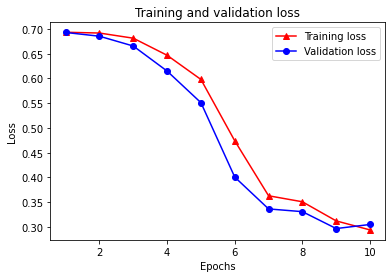

In [44]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()


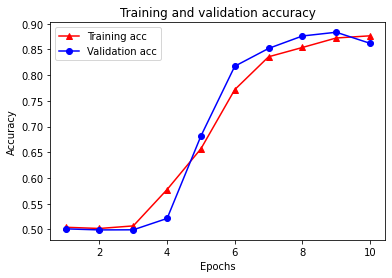

In [45]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## Base + Graph Regularizer

Use the GraphRegularization wrapper from NSL to wrap our bi-lstm model

### Graph Model

In [58]:
# Build a new base LSTM model.
base_reg_model = make_bilstm_model()

In [59]:
# Wrap the base model with graph regularization.
graph_reg_config = nsl.configs.make_graph_reg_config(
    max_neighbors=HPARAMS.num_neighbors,
    multiplier=HPARAMS.graph_regularization_multiplier,
    distance_type=HPARAMS.distance_type,
    sum_over_axis=-1
)
graph_reg_model = nsl.keras.GraphRegularization(
    base_reg_model,
    graph_reg_config
)

graph_reg_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train the Model

In [60]:
graph_reg_history = graph_reg_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=HPARAMS.train_epochs,
    verbose=1
)

Epoch 1/20


2022-05-13 12:51:59.524508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:00.422574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:00.424026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:00.433719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:00.434385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:01.419618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:01.434706: I tensorflow/core/grappler/optimizers/cust

     21/Unknown - 14s 441ms/step - loss: 0.6932 - accuracy: 0.4896 - scaled_graph_loss: 7.4807e-05

2022-05-13 12:52:12.237252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:12.331224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:52:12.338999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


21/21 [==============================] - 25s 987ms/step - loss: 0.6932 - accuracy: 0.4896 - scaled_graph_loss: 7.4807e-05 - val_loss: 0.6929 - val_accuracy: 0.5003
Epoch 2/20
21/21 [==============================] - 18s 858ms/step - loss: 0.6915 - accuracy: 0.4873 - scaled_graph_loss: 7.9284e-05 - val_loss: 0.6841 - val_accuracy: 0.4995
Epoch 3/20
21/21 [==============================] - 18s 850ms/step - loss: 0.6718 - accuracy: 0.5104 - scaled_graph_loss: 0.0048 - val_loss: 0.6442 - val_accuracy: 0.5029
Epoch 4/20
21/21 [==============================] - 18s 874ms/step - loss: 0.6082 - accuracy: 0.6600 - scaled_graph_loss: 0.0339 - val_loss: 0.5264 - val_accuracy: 0.7549
Epoch 5/20
21/21 [==============================] - 18s 860ms/step - loss: 0.5777 - accuracy: 0.7227 - scaled_graph_loss: 0.0589 - val_loss: 0.4826 - val_accuracy: 0.7271
Epoch 6/20
21/21 [==============================] - 17s 845ms/step - loss: 0.5365 - accuracy: 0.8031 - scaled_graph_loss: 0.0654 - val_loss: 0.4293 

### Evaluate the model

In [61]:
graph_reg_results = graph_reg_model.evaluate(
    test_dataset,
    steps=HPARAMS.eval_steps
)

print(graph_reg_results)


2022-05-13 12:59:12.834556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:59:12.918072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 12:59:12.925624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


196/196 [==============================] - 13s 61ms/step - loss: 0.4592 - accuracy: 0.8080
[0.4591517150402069, 0.807960033416748]


### Graph the Results

In [50]:
graph_reg_history_dict = graph_reg_history.history
graph_reg_history_dict.keys()

dict_keys(['loss', 'accuracy', 'scaled_graph_loss', 'val_loss', 'val_accuracy'])

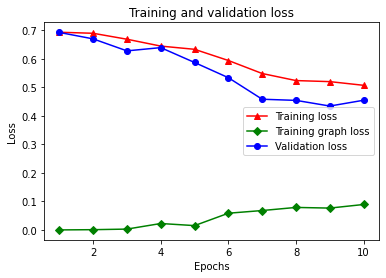

In [51]:
acc = graph_reg_history_dict['accuracy']
val_acc = graph_reg_history_dict['val_accuracy']
loss = graph_reg_history_dict['loss']
graph_loss = graph_reg_history_dict['scaled_graph_loss']
val_loss = graph_reg_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.clf()   # clear figure

# "-r^" is for solid red line with triangle markers.
plt.plot(epochs, loss, '-r^', label='Training loss')
# "-gD" is for solid green line with diamond markers.
plt.plot(epochs, graph_loss, '-gD', label='Training graph loss')
# "-b0" is for solid blue line with circle markers.
plt.plot(epochs, val_loss, '-bo', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.show()

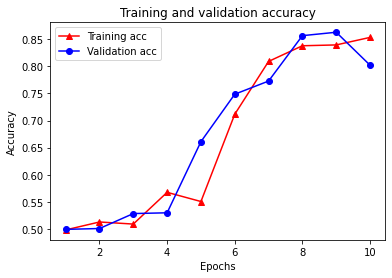

In [52]:
plt.clf()   # clear figure

plt.plot(epochs, acc, '-r^', label='Training acc')
plt.plot(epochs, val_acc, '-bo', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

## Comparing for cases with fewer labeled data in the training

<Figure size 432x288 with 0 Axes>

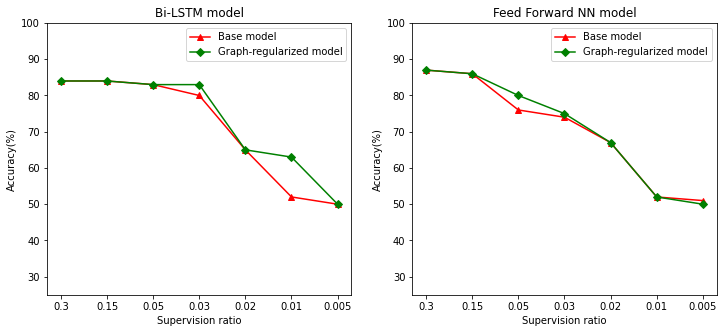

In [54]:
# Accuracy values for both the Bi-LSTM model and the feed forward NN model have
# been precomputed for the following supervision ratios.

supervision_ratios = [0.3, 0.15, 0.05, 0.03, 0.02, 0.01, 0.005]

model_tags = ['Bi-LSTM model', 'Feed Forward NN model']
base_model_accs = [[84, 84, 83, 80, 65, 52, 50], [87, 86, 76, 74, 67, 52, 51]]
graph_reg_model_accs = [[84, 84, 83, 83, 65, 63, 50],
                        [87, 86, 80, 75, 67, 52, 50]]

plt.clf()  # clear figure

fig, axes = plt.subplots(1, 2)
fig.set_size_inches((12, 5))

for ax, model_tag, base_model_acc, graph_reg_model_acc in zip(
        axes, model_tags, base_model_accs, graph_reg_model_accs):

    # "-r^" is for solid red line with triangle markers.
    ax.plot(base_model_acc, '-r^', label='Base model')
    # "-gD" is for solid green line with diamond markers.
    ax.plot(graph_reg_model_acc, '-gD', label='Graph-regularized model')
    ax.set_title(model_tag)
    ax.set_xlabel('Supervision ratio')
    ax.set_ylabel('Accuracy(%)')
    ax.set_ylim((25, 100))
    ax.set_xticks(range(len(supervision_ratios)))
    ax.set_xticklabels(supervision_ratios)
    ax.legend(loc='best')

plt.show()